# Proje-2: Human or AI - Veri Analizi ve Model Eğitimi

## Proje Tanımı
Bu proje, metin tabanlı verilerin (makale özetleri) analiz edilerek, içeriğin bir **İnsan** tarafından mı yoksa bir **Yapay Zeka (AI)** tarafından mı yazıldığını tespit etmeyi amaçlar.

**Proje Süreci:**
1.  **Veri Hazırlığı:** 3.000 İnsan ve 3.000 AI verisinin birleştirilmesi.
2.  **EDA (Keşifçi Veri Analizi):** Veri setinin yapısal incelenmesi.
3.  **Önişleme:** Metin temizliği ve gürültüden arındırma.
4.  **Model Eğitimi:** 3 farklı ML algoritması (Naive Bayes, Logistic Regression, Random Forest) ile eğitim.
5.  **Değerlendirme:** ROC Eğrileri, Karmaşıklık Matrisi ve Başarı Metrikleri.

In [20]:
# Gerekli Kütüphanelerin Yüklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pickle
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Scikit-Learn Modülleri
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Ayarlar
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# NLTK Kaynakları
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print("✅ Kütüphaneler ve ayarlar yüklendi.")

✅ Kütüphaneler ve ayarlar yüklendi.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Murat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Murat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Murat\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 1. Veri Setlerinin Yüklenmesi ve Birleştirilmesi (User Story-1)
Proje kapsamında toplanan **Human** ve **AI** veri setleri ayrı dosyalardan okunarak tek bir veri çerçevesinde (DataFrame) birleştirilecektir. Toplam hedeflenen veri sayısı 6.000'dir.

In [21]:
# Veri setlerini yükleme
try:
    df_ai = pd.read_csv('../data/ai_data.csv')
    df_human = pd.read_csv('../data/human_data.csv')

    # Etiket kontrolü ve atama
    if 'label' not in df_ai.columns:
        df_ai['label'] = 'AI'
    if 'label' not in df_human.columns:
        df_human['label'] = 'Human'

    # Verileri birleştirme
    df = pd.concat([df_ai, df_human], axis=0).reset_index(drop=True)

    print(f"✅ Veri Setleri Birleştirildi.")
    print(f"Toplam Satır Sayısı: {df.shape[0]}")
    print("-" * 30)
    print(df['label'].value_counts())
    
except FileNotFoundError:
    print("❌ HATA: 'ai_data.csv' veya 'human_data.csv' dosyası bulunamadı.")

❌ HATA: 'ai_data.csv' veya 'human_data.csv' dosyası bulunamadı.


## 2. Keşifçi Veri Analizi (EDA)
Model eğitimine geçmeden önce veri setindeki sınıf dağılımı ve metin uzunlukları incelenerek veri dengesi kontrol edilecektir.

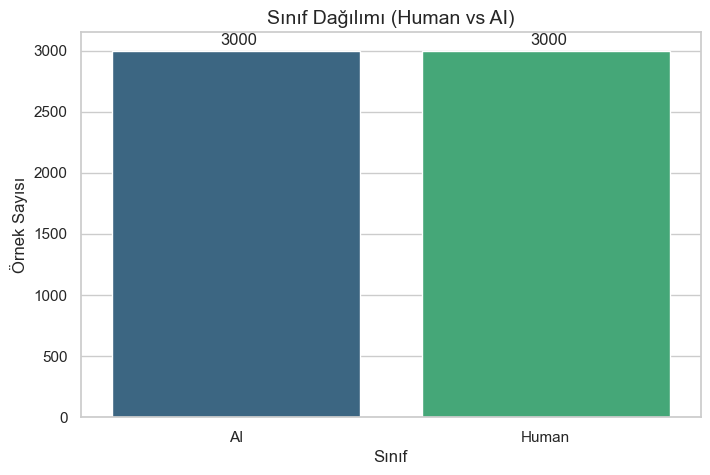

In [22]:
# Sınıf Dağılımı Grafiği
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=df, palette='viridis')
plt.title('Sınıf Dağılımı (Human vs AI)', fontsize=14)
plt.xlabel('Sınıf')
plt.ylabel('Örnek Sayısı')

# Sayıları yazdırma
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + 0.35, p.get_height() + 50))

plt.show()

Metin Uzunluk İstatistikleri:


word_count                                                           \
           count        mean        std   min    25%    50%    75%    max   
label                                                                       
AI        3000.0   97.826333   6.529246  75.0   94.0   98.0  102.0  127.0   
Human     3000.0  175.608667  43.988626  18.0  149.0  176.0  205.0  429.0   

      char_count                                                           \
           count         mean         std    min     25%     50%      75%   
label                                                                       
AI        3000.0   760.208667   52.780164  551.0   725.0   760.0   795.00   
Human     3000.0  1319.365667  333.504437  118.0  1128.0  1337.0  1551.25   

               
          max  
label          
AI      964.0  
Human  3199.0

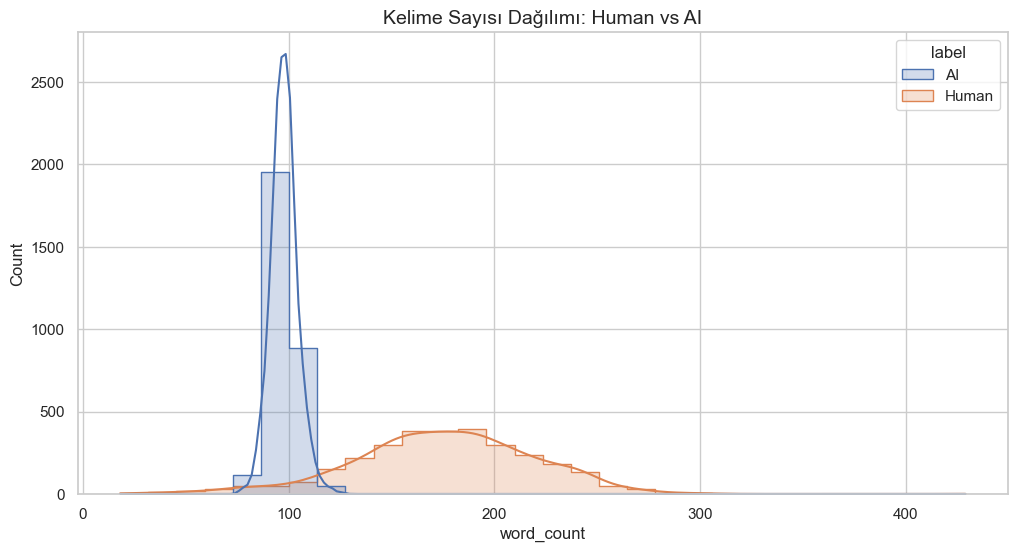

In [23]:
# Metin İstatistikleri (Feature Engineering)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# İstatistiksel Özet
print("Metin Uzunluk İstatistikleri:")
display(df.groupby('label')[['word_count', 'char_count']].describe())

# Histogram (Kelime Sayısı Dağılımı)
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='label', kde=True, element="step", bins=30)
plt.title('Kelime Sayısı Dağılımı: Human vs AI', fontsize=14)
plt.show()

## 3. Veri Temizleme ve Önişleme (User Story-2)
Ham metinler, makine öğrenmesi modellerinin daha iyi performans göstermesi için temizlenecektir.
**Yapılacak İşlemler:**
* Küçük harfe çevirme (Lowercasing)
* URL, HTML etiketi ve Noktalama işareti temizliği
* Stopwords (Etkisiz kelime) temizliği
* Lemmatization (Kelime kökü bulma)

In [24]:
# Temizleme Fonksiyonu
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()                                  # Küçük harf
    text = re.sub(r'https?://\S+|www\.\S+', '', text)         # URL
    text = re.sub(r'<.*?>', '', text)                         # HTML
    text = re.sub(r'\[.*?\]', '', text)                       # Köşeli parantez (atıf)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text) # Noktalama
    text = re.sub(r'\w*\d\w*', '', text)                      # Rakam içeren kelimeler
    
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Temizliği Uygulama
print("⏳ Metin temizleniyor...")
df['clean_text'] = df['text'].apply(clean_text)
print("✅ Temizleme tamamlandı.")
display(df[['text', 'clean_text']].head(3))

⏳ Metin temizleniyor...
✅ Temizleme tamamlandı.


,text,clean_text
0,This study investigates the stability and long...,study investigates stability longterm performa...
1,The intermittency of variable renewable energy...,intermittency variable renewable energy source...
2,A comparative Life Cycle Assessment (LCA) was ...,comparative life cycle assessment lca conducte...


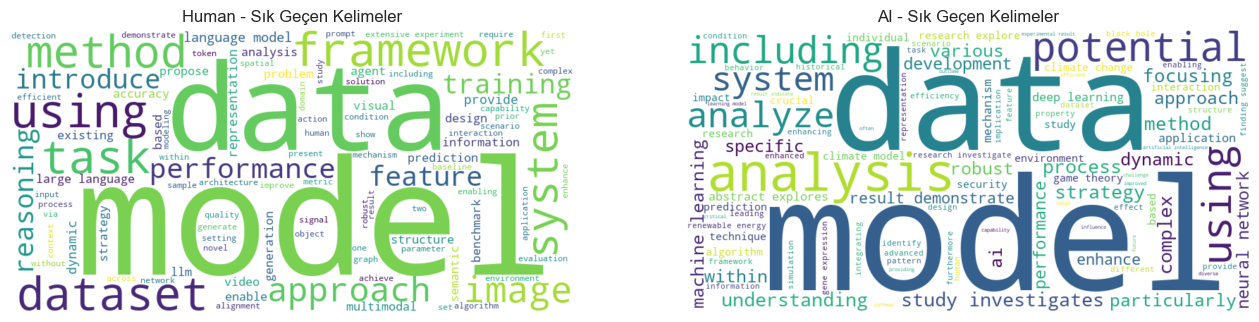

In [25]:
# WordCloud Görselleştirmesi
human_text = " ".join(df[df['label'] == 'Human']['clean_text'])
ai_text = " ".join(df[df['label'] == 'AI']['clean_text'])

wc = WordCloud(width=800, height=400, background_color='white', max_words=100)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wc.generate(human_text), interpolation='bilinear')
plt.title('Human - Sık Geçen Kelimeler')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wc.generate(ai_text), interpolation='bilinear')
plt.title('AI - Sık Geçen Kelimeler')
plt.axis('off')
plt.show()

## 4. Model Eğitimi (User Story-3)
Proje gereksinimleri doğrultusunda **3 farklı ML algoritması** eğitilecektir.

1.  **Naive Bayes (MultinomialNB)**
2.  **Logistic Regression**
3.  **Random Forest Classifier**

Veri seti **%80 Eğitim**, **%20 Test** olarak ayrılacaktır.

In [26]:
# Train-Test Split
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vektörleştirme
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print(f"Eğitim Seti: {X_train_vec.shape}")
print(f"Test Seti: {X_test_vec.shape}")

Eğitim Seti: (4800, 5000)
Test Seti: (1200, 5000)


In [27]:
# Modellerin Tanımlanması ve Eğitimi
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
performance_log = []

print("🚀 Model Eğitimi Başladı...\n")

for name, model in models.items():
    # Eğitim
    model.fit(X_train_vec, y_train)
    
    # Tahmin
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    # Loglama (User Story-7: Hiperparametre Kaydı)
    performance_log.append({
        "Model": name,
        "Accuracy": acc,
        "Params": str(model.get_params())
    })
    
    print(f"🔹 {name} Accuracy: %{acc*100:.2f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

🚀 Model Eğitimi Başladı...

🔹 Naive Bayes Accuracy: %94.92
              precision    recall  f1-score   support

          AI       0.96      0.93      0.95       600
       Human       0.94      0.96      0.95       600

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200

--------------------------------------------------
🔹 Logistic Regression Accuracy: %97.83
              precision    recall  f1-score   support

          AI       0.98      0.98      0.98       600
       Human       0.98      0.98      0.98       600

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200

--------------------------------------------------
🔹 Random Forest Accuracy: %98.67
              precision    recall  f1-score   support

          AI       0.98      0.99      0.99       600
    

## 5. Model Performans Değerlendirmesi (User Story-7 & Kalite)
Modellerin başarısını görselleştirmek için **Confusion Matrix** ve **ROC Curves** çizdirilecektir.

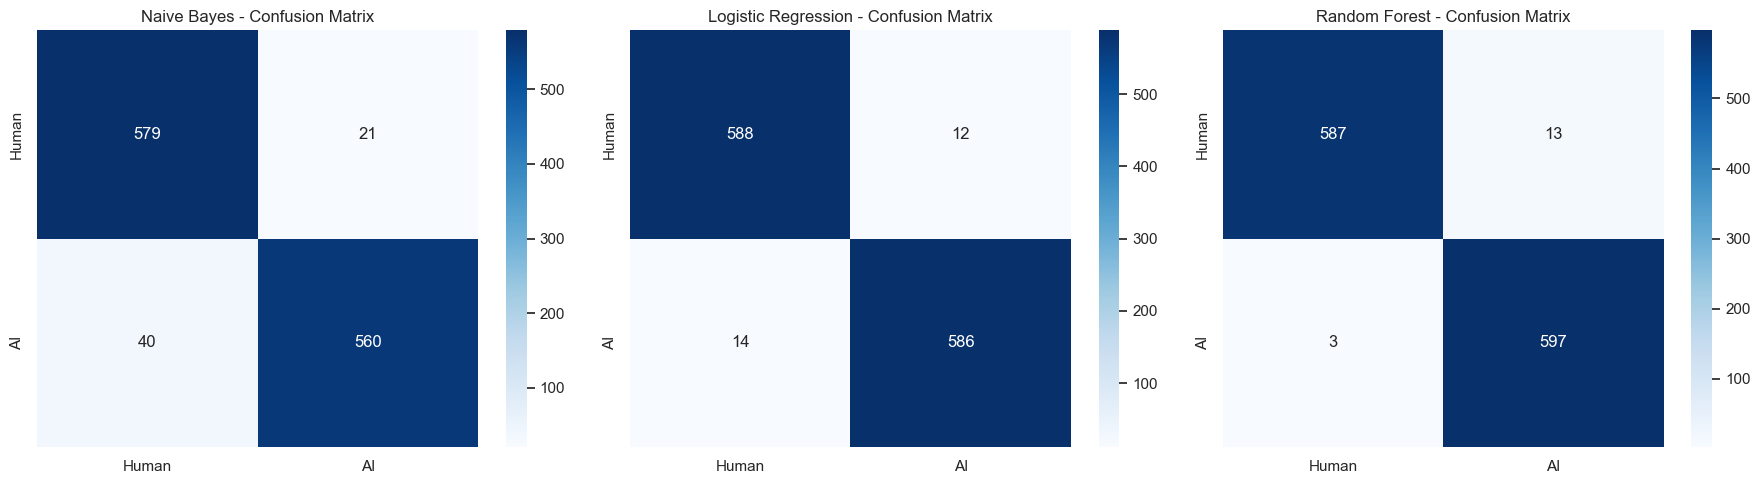

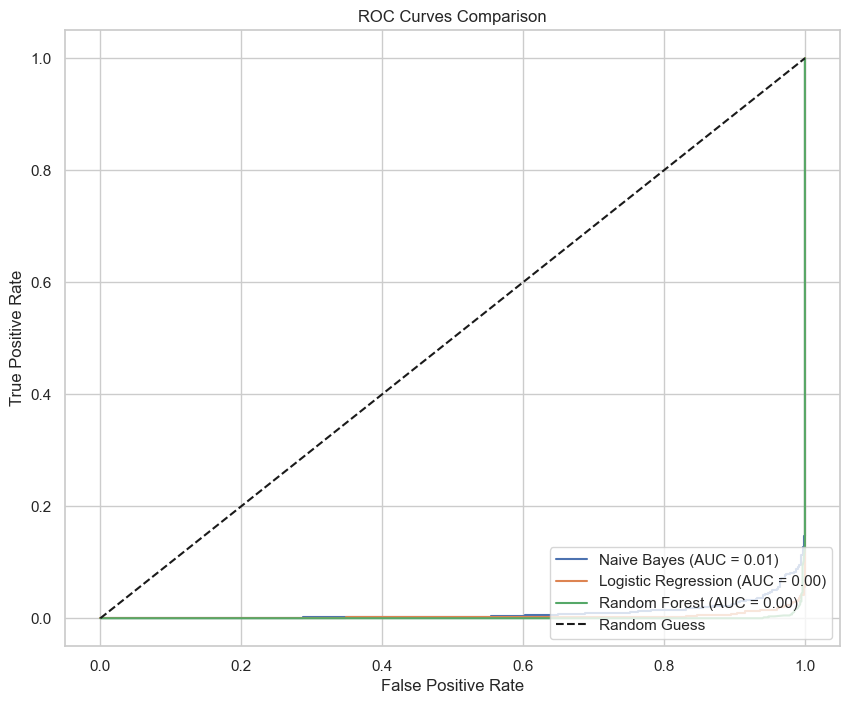

In [28]:
# 1. Confusion Matrix Görselleştirmesi
plt.figure(figsize=(18, 5))
for i, (name, model) in enumerate(models.items()):
    plt.subplot(1, 3, i+1)
    y_pred = model.predict(X_test_vec)
    cm = confusion_matrix(y_test, y_pred, labels=['Human', 'AI'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
    plt.title(f'{name} - Confusion Matrix')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

# 2. ROC Eğrisi Görselleştirmesi
y_test_bin = y_test.map({'Human': 0, 'AI': 1}) # ROC için sayısal dönüşüm

plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test_vec)[:, 1] # AI sınıfı olasılığı
        fpr, tpr, _ = roc_curve(y_test_bin, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.savefig('roc_curves.png')
plt.show()

In [29]:
# Sonuçların ve Modellerin Kaydedilmesi (User Story-4 Entegrasyon Hazırlığı)

# 1. Modelleri Kaydet
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

for name, model in models.items():
    filename = f"{name.replace(' ', '_').lower()}_model.pkl" # örn: naive_bayes_model.pkl
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

# 2. En iyi modeli ayrıca kaydet
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# 3. Hiperparametre Loglarını CSV yap
pd.DataFrame(performance_log).to_csv('model_logs.csv', index=False)

print(f"✅ Tüm süreç tamamlandı.")
print(f"🏆 En Başarılı Model: {best_model_name} (Accuracy: %{results[best_model_name]*100:.2f})")
print("📂 Modeller (.pkl) ve Görseller (.png) kaydedildi.")

✅ Tüm süreç tamamlandı.
🏆 En Başarılı Model: Random Forest (Accuracy: %98.67)
📂 Modeller (.pkl) ve Görseller (.png) kaydedildi.
